In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm


In [2]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
L = upper - lower
x = jnp.linspace(0, 1, 1000)
boundary = jnp.array([[lower, upper]]).T
boundary_conditions = jnp.zeros(shape = (2, )) # Dirichlet boundary conditions
domain = jnp.array([lower, upper])

In [3]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

# Generating white noise

To test the accuracy of our method we will sample 

$$
\xi \sim \sum_{i=j}^N \xi_j \sqrt{2}\sin(j \pi x)
$$

and project onto a tent function basis:

$$
[\xi, \varphi] = \sum_{i=1}^N \xi_i \langle  \varphi, \sqrt{2}\sin(j \pi x) \rangle
$$

The inner product will be computed using the DST. 

In [4]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, vmap_compute_sine_coef, compute_sine_coefficients

In [153]:
# Generate our white noise 
key = random.PRNGKey(111)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))]) 
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

16384


In [154]:
# Generate our Galerkin basis
n_intervals = 2**10
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

1024


In [155]:
# Utilities for the tent functions
def tent_function(x, epsilon, center):
    return jnp.maximum(0, 1 - jnp.abs(x - center) / epsilon)/epsilon

vmap_tent = jit(vmap(tent_function, in_axes=(None, None, 0)))

In [156]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
f_tent = tent_proj_coef@coef_f # We can now evaluate the action of white noise on the tent functions
u_tent = tent_proj_coef@coef_u # We can now evaluate the action of white noise on the tent functions

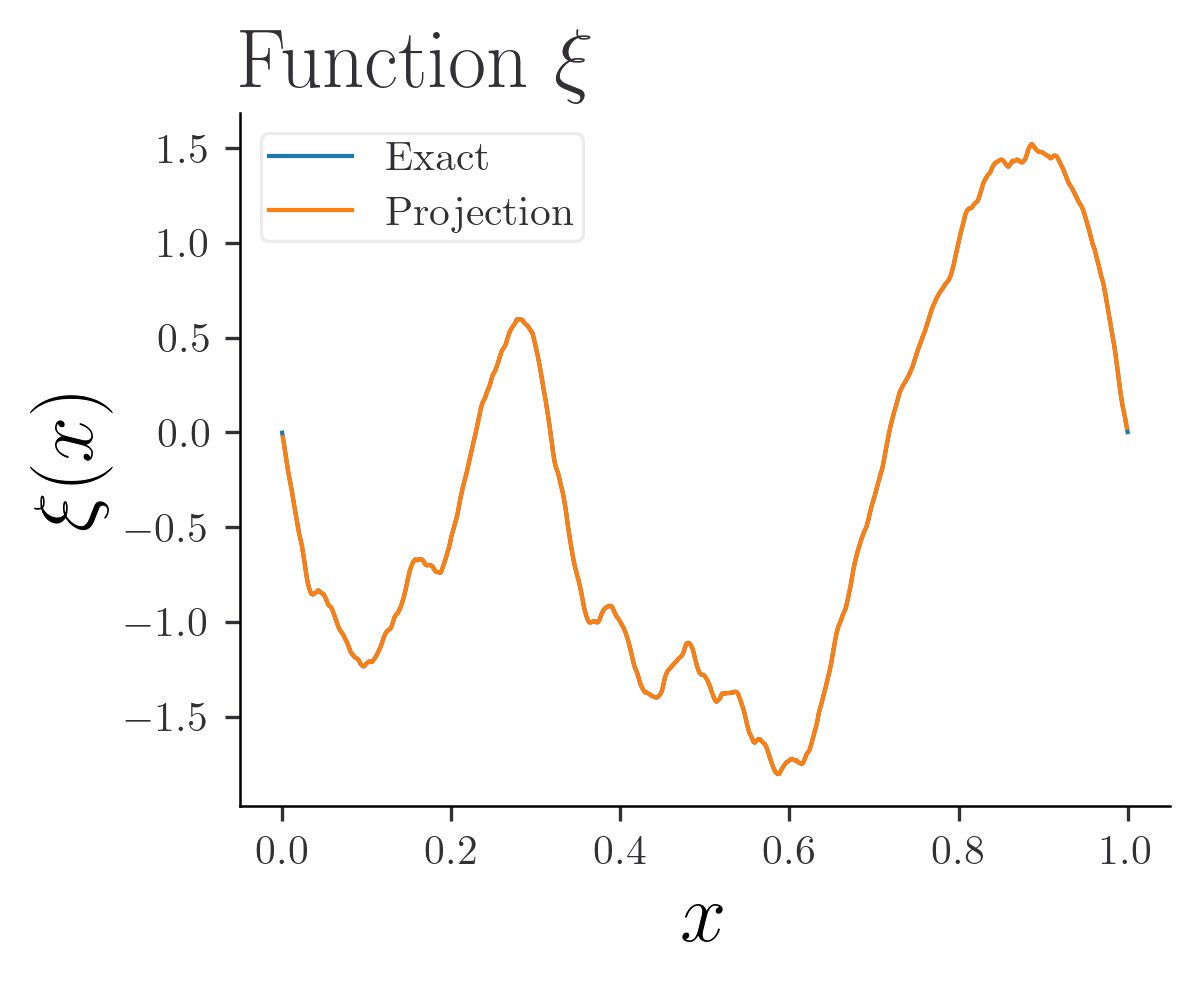

In [157]:
fig = plt.figure(figsize=(width, height))

plt.plot(domain_finest, u_values, label = r"Exact")
plt.plot(centers[1:-1], u_tent, label = r"Projection")

plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.legend()

plt.show()

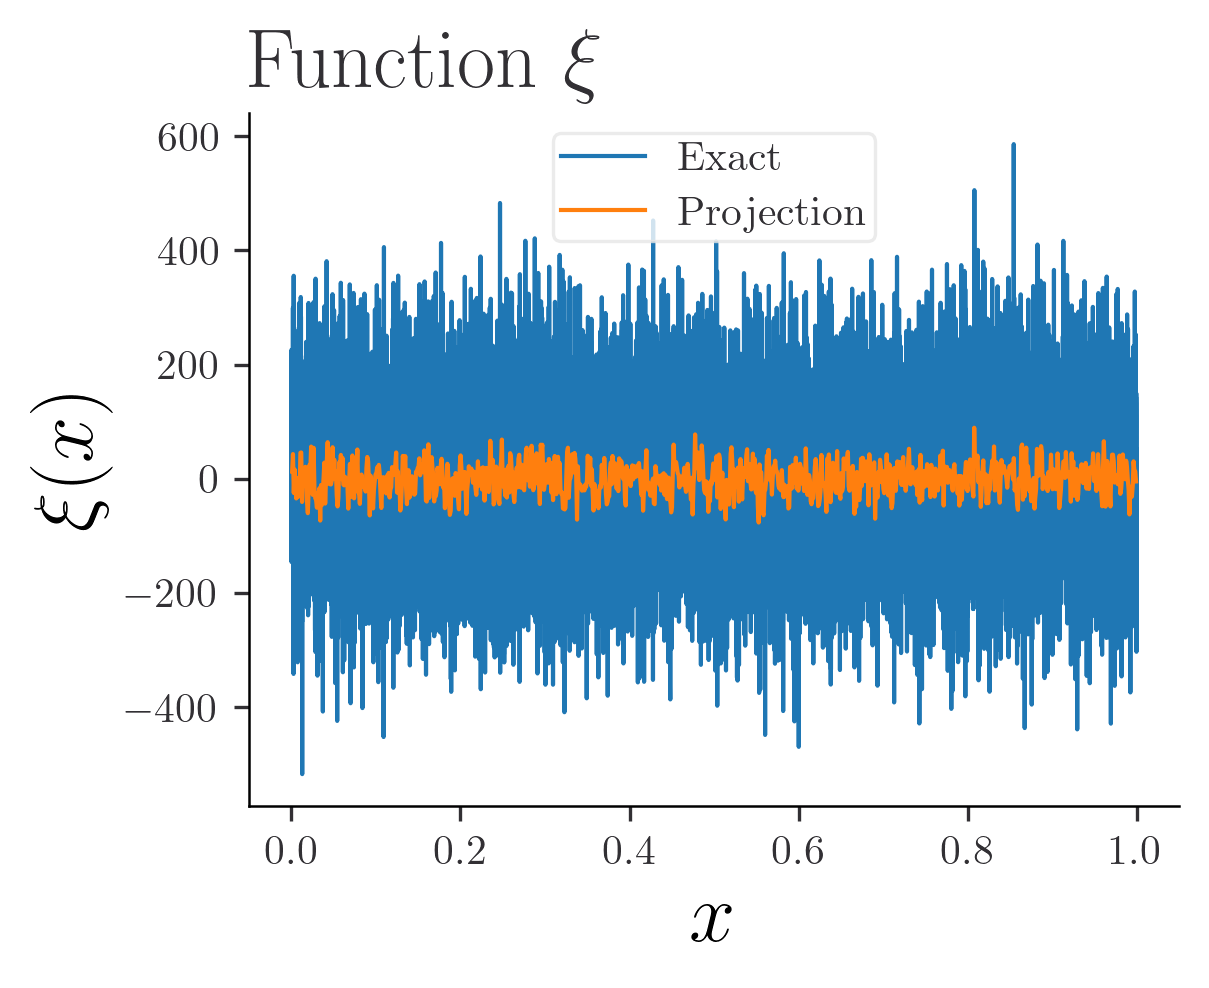

In [158]:
fig = plt.figure(figsize=(width, height))

plt.plot(domain_finest, f_values, label = r"Exact")
plt.plot(centers[1:-1], f_tent, label = r"Projection")

plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.legend()

plt.show()

# Solve the PDE

In [159]:
b =lambda x : jnp.ones_like(x)*1.0

In [205]:
# Generate our Galerkin basis
n_intervals = 2**9
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

512


In [206]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
f_tent = tent_proj_coef@coef_f # We can now evaluate the action of white noise on the tent functions
u_tent = tent_proj_coef@coef_u # We can now evaluate the action of white noise on the tent functions

In [306]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

n_quad = 3
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)

5


In [307]:
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

In [308]:
k_quad.shape

(511, 6)

In [309]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)

In [310]:
element_quad

Array([0.11270167, 0.5       , 0.88729833], dtype=float64)

In [292]:
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

In [293]:
import importlib
import utils_optim
importlib.reload(utils_optim)

from utils_optim import kernel_linear_solver

In [294]:
length_scale = 1.0
solver = kernel_linear_solver(length_scale,  tent_quad, k_quad, boundary[:, None], boundary_conditions, nu)


In [295]:
rhs = jnp.hstack([boundary_conditions, f_tent])
rhs.shape

(513,)

In [296]:
import importlib
import utils_elliptic_coef
importlib.reload(utils_elliptic_coef)

<module 'utils_elliptic_coef' from '/home/matthieu/StochasticPDEs/solving_elliptic/utils_elliptic_coef.py'>

In [297]:
root_b = b(k_quad)

In [298]:
solver.solve_linear_prob(f_tent, None, root_b, jnp.eye(n_meas))

In [299]:
pred = solver.evaluate_solution(domain_finest)

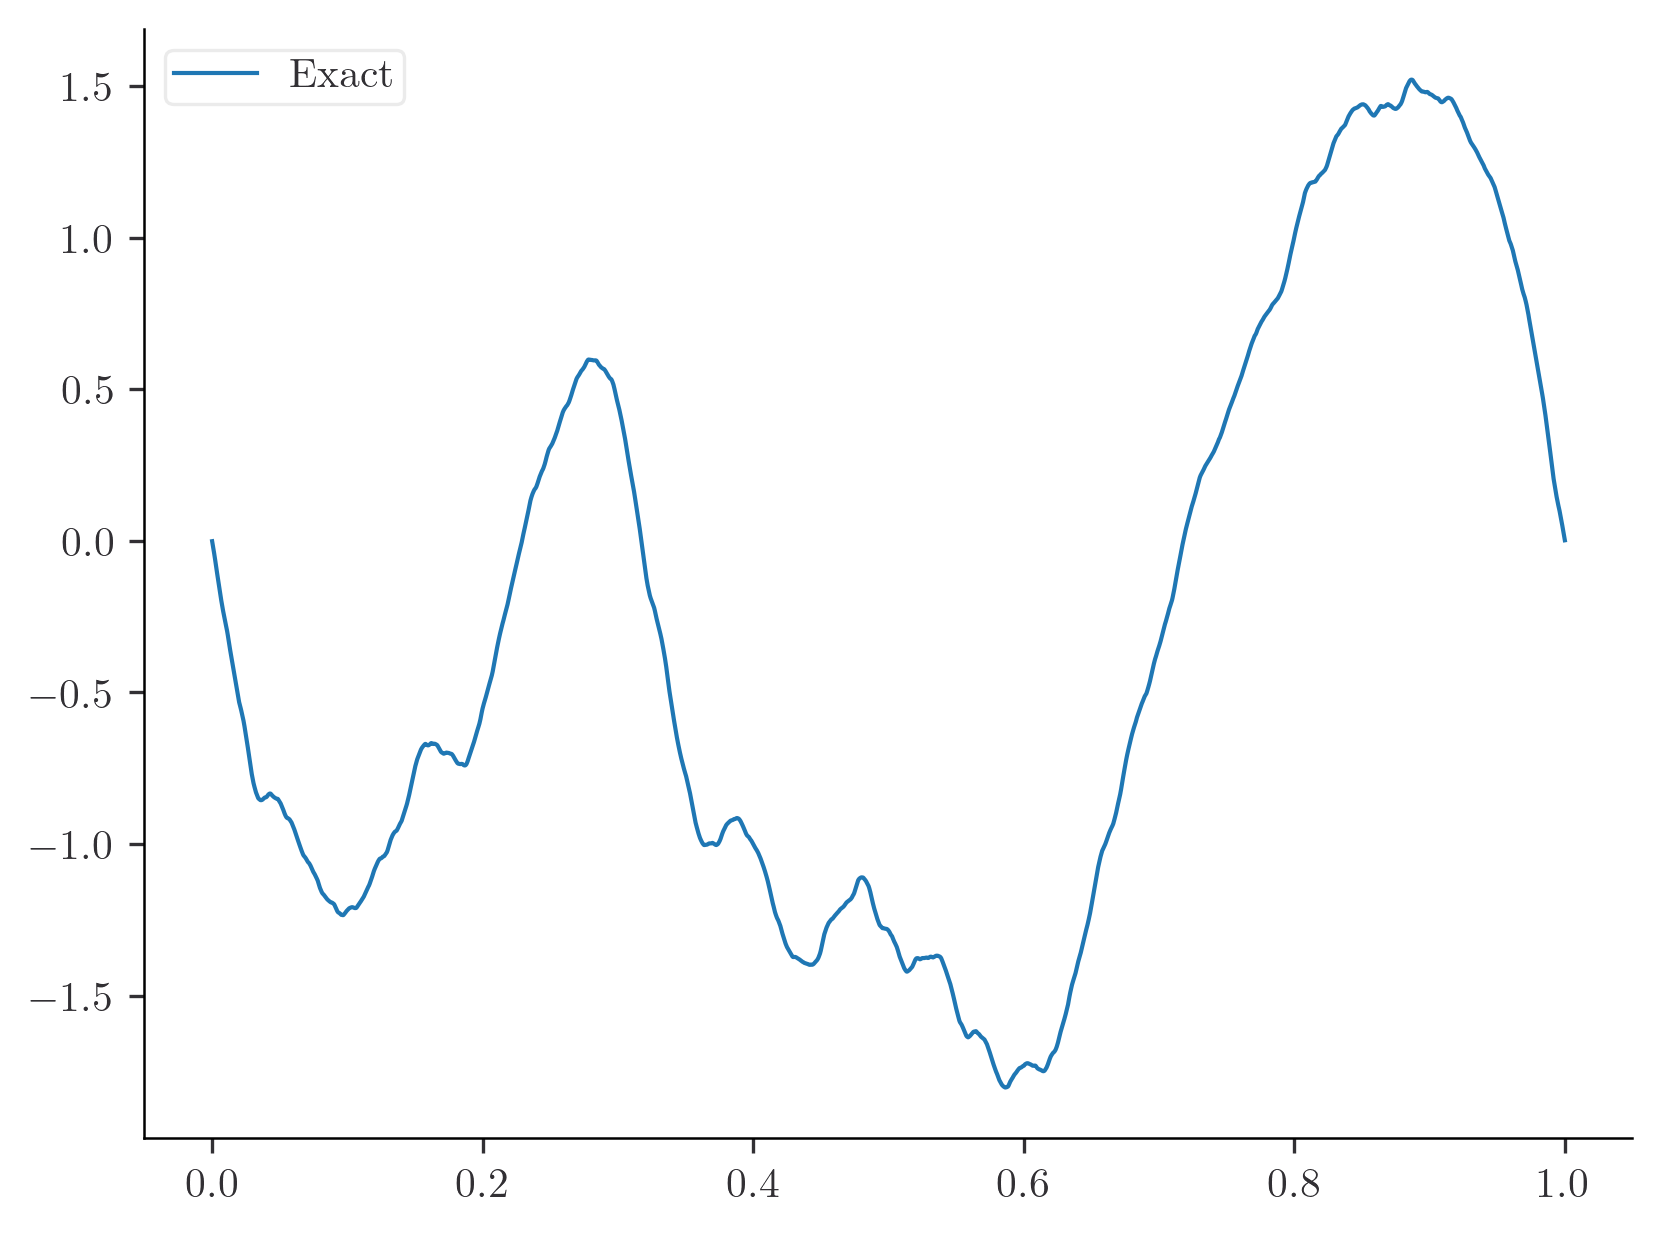

In [300]:
#plt.plot(domain_finest, pred, label = r"Predicted")
plt.plot(domain_finest, u_values, label = r"Exact")
plt.legend()

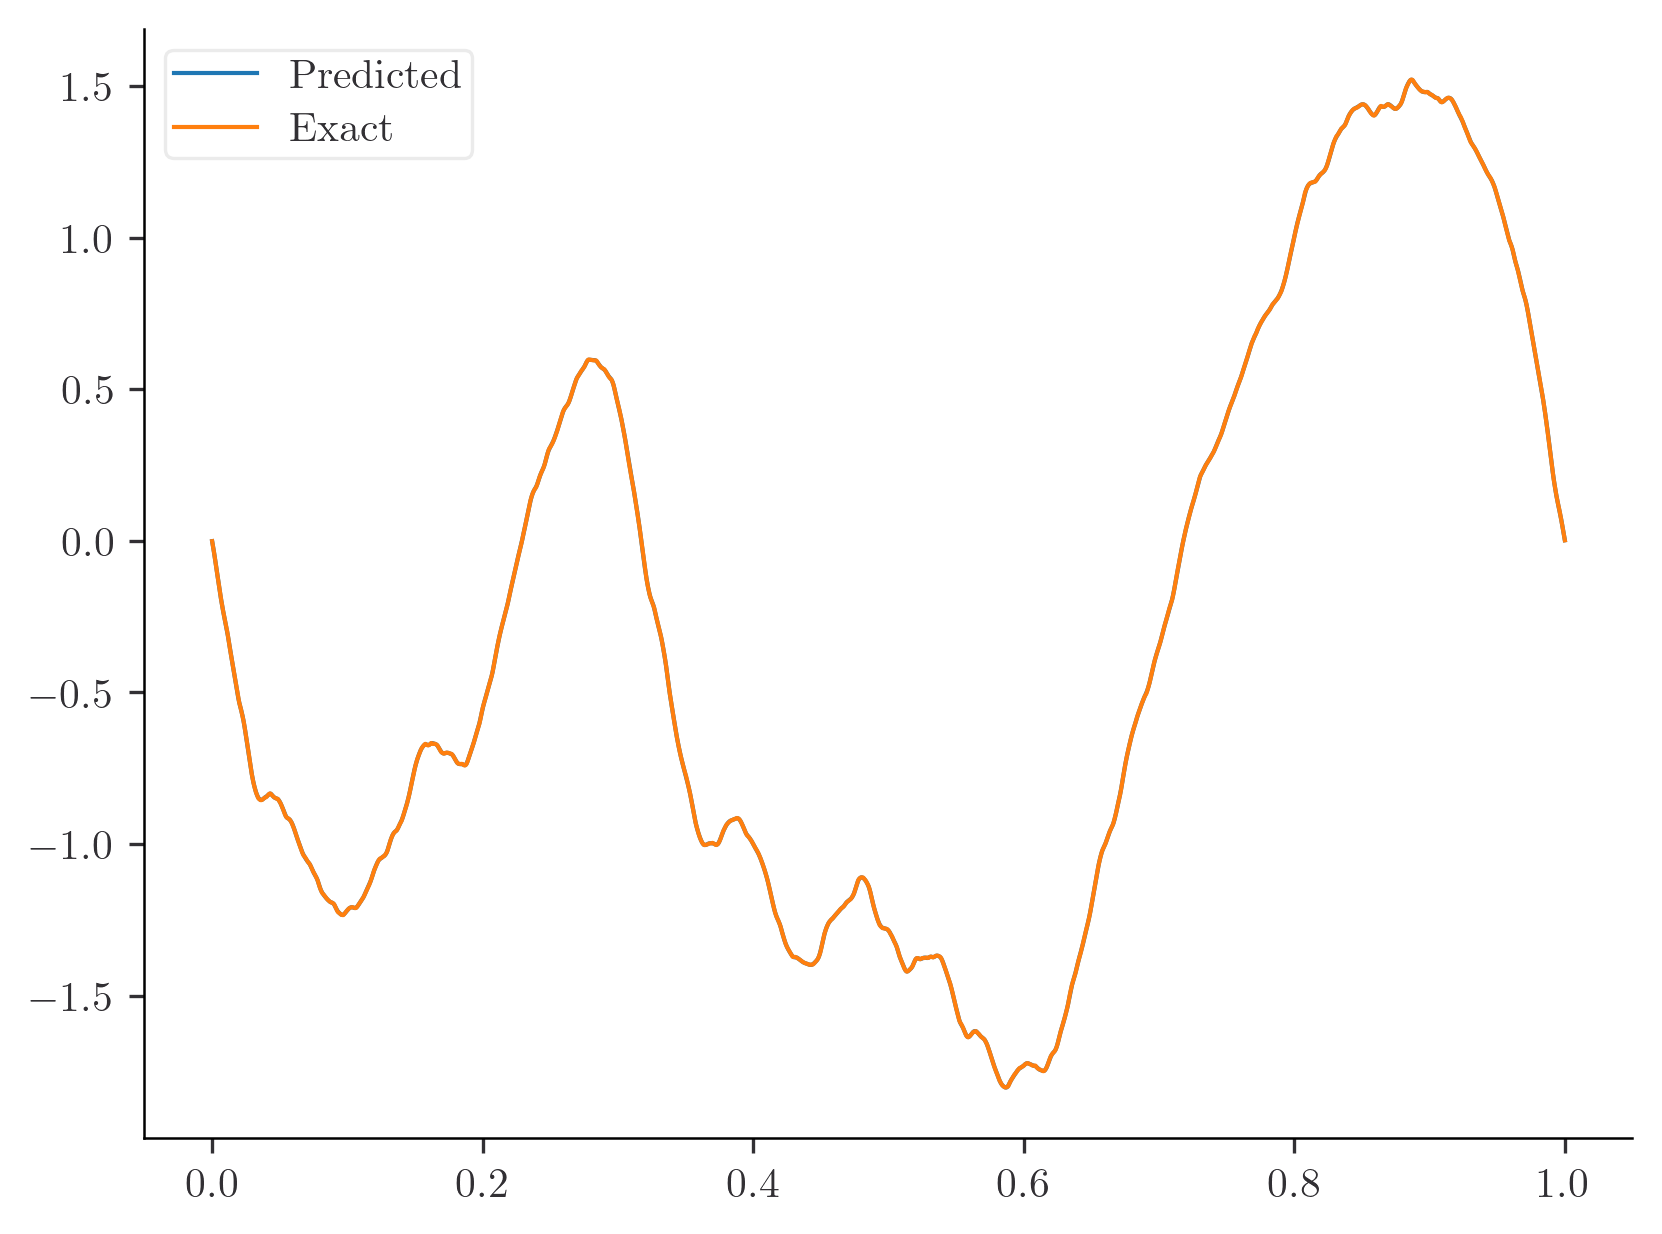

In [301]:
plt.plot(domain_finest, pred, label = r"Predicted")
plt.plot(domain_finest, u_values, label = r"Exact")
plt.legend()

In [302]:
from scipy import integrate
def compute_1d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

In [303]:
compute_1d_error(pred, u_values, domain_finest, domain_finest)

(Array(0.00066223, dtype=float64), Array(0.0006274, dtype=float64))

In [255]:
compute_1d_error(pred, u_values, domain_finest, domain_finest)

(Array(0.0006434, dtype=float64), Array(0.00060956, dtype=float64))

In [233]:
import importlib
import utils_elliptic_coef
importlib.reload(utils_elliptic_coef)

from utils_elliptic_coef import linear_form_K

In [78]:
root_b = b(m_tool.root_psi)
root_b.shape
m_tool.root_psi.shape, boundary.shape

((32, 10), (2,))

In [79]:
theta_11, theta_21, theta_22 = theta_blocks(boundary[:, None],m_tool.psi_matrix[0], m_tool.root_psi, length_scale, nu, root_b)

In [55]:
theta_22_original, theta_21_original, theta_11_original = theta_22, theta_21, theta_11

In [73]:
import importlib
import utils_elliptic_coef
importlib.reload(utils_elliptic_coef)


from utils_elliptic_coef import linear_form_K, theta_blocks

In [71]:
m_tool.psi_matrix[:1].shape, m_tool.psi_matrix[:1].shape, m_tool.root_psi.shape, boundary.shape

((1, 10), (1, 10), (32, 10), (2,))

In [74]:
theta_11, theta_21, theta_22 = theta_blocks(boundary[:, None],m_tool.psi_matrix[0], m_tool.root_psi, length_scale, nu, root_b)

In [75]:
jnp.mean(jnp.abs(theta_11 - theta_11_original)), jnp.mean(jnp.abs(theta_21 - theta_21_original)), jnp.mean(jnp.abs(theta_22 - theta_22_original))

(Array(0., dtype=float64),
 Array(2.16840434e-16, dtype=float64),
 Array(4.16550475e-16, dtype=float64))

In [15]:
from utils_optim import kernel_linear_solver

In [22]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

In [27]:
n_quad = 5 
print(2*n_quad-1)
x_q, w_q = roots_legendre(n_quad)
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)

9


In [32]:
x_quad.flatten().shape, x_quad.shape

((5120,), (1024, 5))

In [35]:
vmap_L_b_xy(x_quad.flatten(), x_quad.flatten(), 1.0,nu, b(x_quad.flatten()), b(x_quad.flatten())).shape

(5120, 5120)

In [33]:
1024*1024*5

5242880

In [ ]:
def project_tent_basis(f, element, w_quad, include_boundary):

    F_1 = jnp.sum(f*element*w_quad, axis = 1)
    F_2 = jnp.sum(f*element[::-1]*w_quad, axis = 1)



    if include_boundary:
        result = jnp.hstack([F_2[0], F_1[:-1] + F_2[1:], F_1[-1]])
    else:
        result = F_1[:-1] + F_2[1:]

    return result

In [ ]:
length_scale = 1.0

In [77]:
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, x_quad, length_scale, nu, b(x_quad))
theta_22 = vmap_L_b_xy(x_quad, x_quad, length_scale,nu, b(x_quad), b(x_quad))

KeyboardInterrupt: 

In [ ]:
theta_22.shape